In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
eps = np.finfo(float).eps
from numpy import log2 as log


In [ ]:
df=pd.read_csv('/content/play_tennis.csv')
df = df.drop('day',axis=1)

In [ ]:
df.head(14)

,outlook,temp,humidity,wind,play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [ ]:
df.shape

(14, 5)

In [ ]:
df.columns

Index(['outlook', 'temp', 'humidity', 'wind', 'play'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   outlook   14 non-null     object
 1   temp      14 non-null     object
 2   humidity  14 non-null     object
 3   wind      14 non-null     object
 4   play      14 non-null     object
dtypes: object(5)
memory usage: 688.0+ bytes


In [ ]:
df.describe()

,outlook,temp,humidity,wind,play
count,14,14,14,14,14
unique,3,3,2,2,2
top,Sunny,Mild,High,Weak,Yes
freq,5,6,7,8,9


In [ ]:
def find_entropy(df):
    #target column
    target = df.keys()[-1]
    entropy = 0
    values = df[target].unique()
    #calc entropy
    for value in values:
        fraction = df[target].value_counts()[value]/len(df[target])
        entropy += -fraction*np.log2(fraction)
    return entropy

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in df.columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [ ]:
def average_information(df,attribute):
  target = df.keys()[-1]   #target column
  target_variables = df[target].unique()  #This gives all 'Yes' and 'No'
  variables = df[attribute].unique()    #This gives different features in that attribute (like 'Hot','Cold' in Temperature)
  entropy2 = 0
  for variable in variables:
      entropy = 0
      for target_variable in target_variables:
          num = len(df[attribute][df[attribute]==variable][df[target] ==target_variable])
          den = len(df[attribute][df[attribute]==variable])
          fraction = num/(den+eps)
          entropy += -fraction*log(fraction+eps)
      fraction2 = den/len(df)
      entropy2 += -fraction2*entropy
  return abs(entropy2)

In [ ]:
def find_winner(df):
    IG = []
    for key in df.keys()[:-1]:
        IG.append(find_entropy(df)-average_information(df,key))
    return df.keys()[:-1][np.argmax(IG)]

In [ ]:
def get_subtable(df, node,value):
  return df[df[node] == value].reset_index(drop=True)

In [ ]:
def buildTree(df,tree=None):
    target = df.keys()[-1]   #target column

    #Here we build our decision tree

    #Get attribute with maximum information gain
    node = find_winner(df)

    #Get distinct value of that attribute e.g Salary is node and Low,Med and High are values
    attValue = np.unique(df[node])

    #Create an empty dictionary to create tree
    if tree is None:
        tree={}
        tree[node] = {}

    #We make loop to construct a tree by calling this function recursively.
    #In this we check if the subset is pure and stops if it is pure.

    for value in attValue:

        subtable = get_subtable(df,node,value)
        clValue,counts = np.unique(subtable[target],return_counts=True)

        if len(counts)==1:#Checking purity of subset
            tree[node][value] = clValue[0]
        else:
            tree[node][value] = buildTree(subtable) #Calling the function recursively

    return tree

In [ ]:
tree = buildTree(df)

In [ ]:
import pprint
pprint.pprint(tree)

{'outlook': {0: 1, 1: {'wind': {0: 0, 1: 1}}, 2: {'humidity': {0: 0, 1: 1}}}}


In [ ]:
# Define features and target variable
X = df.iloc[:,:-1]
y = df.iloc[:,-1]


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

In [ ]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = clf.predict(X_test)

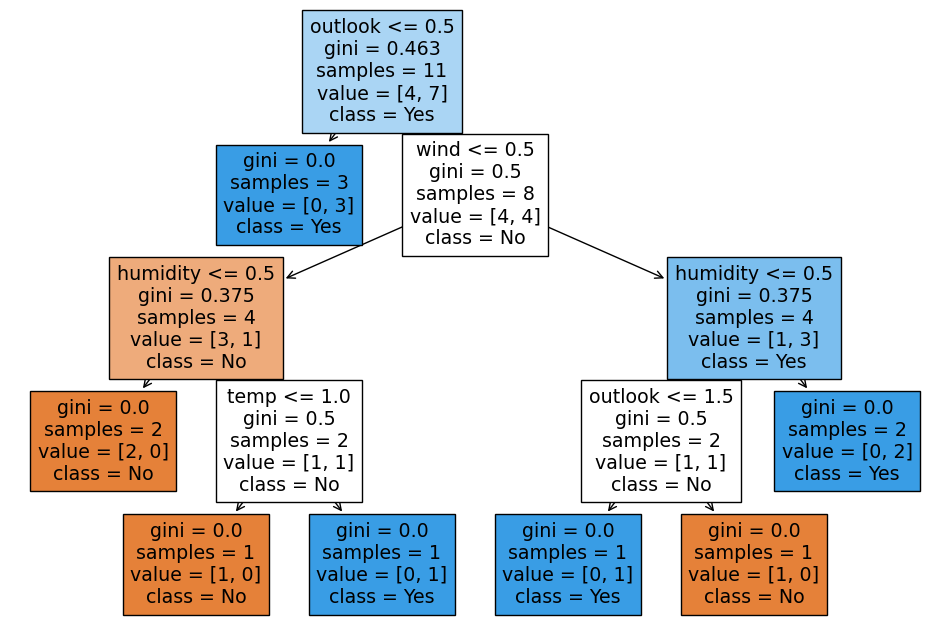

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=label_encoders['play'].classes_, filled=True)
plt.show()